In [89]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.constants import N_A, R

In [62]:
#terms for subsolar latitude calculation from Trafton 1984
alpha0 = 76.3117
alpha1 = .0381 #1/yr
beta0 = 18.503
beta1 = 0.00986 #1/yr

def SVP_CH4(T): #saturation vapor pressure of methane, Armstrong 1953
    log10P = 7.69540 - 532.2/(T+1.842)
    P = 10.0**log10P #mm Hg
    P = 133.332*P #Pa
    return P

def eq_T(P): #equlibrium temperature of methane (reverse of SVP_CH4)
    P = P/133.332 #mm Hg
    log10P = np.log10(P)
    T = -532.2/(log10P - 7.69540)- 1.842
    return T
def calc_cond_rate(pCH4,pN2,u=24): #condensation mass flux from Stansberry 1996, approximated from figures 4,5
    rate = .032 #g cm^-2 yr^-1 ... at 1%= .01 mixing ratio, total pressure 19 microbars
    mr = pCH4/pN2
    rate = mr*rate/.01  #account for different mixing ratio
    C = np.log10(2.5)/np.log10(3.05) #Ratio_P = C*Ratio_J
    p0 = 19e-6*100000
    rate = (pN2/p0)**C *rate 
    rate = u*rate/24
    return rate #g cm^-2 yr^-1
# def altered_cond_rate(c_r,T,T_eq): #unused
#     rate = c_r*np.exp(-1/(4*np.abs(T-T_eq)))
#     return rate
def calc_sub_rate(T): #sublimation mass flux from Stansberry 1996, approximated from figures 4,5
    rate = 3.329e-13*np.exp(.5508*T)
    return rate #g cm^-2 yr^-1


In [179]:
start_t = 1 #yr 
end_t = 3000
steps = 5000
Δt = (end_t-start_t)/steps
t = np.linspace(start_t,end_t,steps)
sinphi = (.4636*np.cos(alpha0 - alpha1*t) + .3495*np.sin(alpha0-beta0+(beta1-alpha1)*t
             + .0251*np.sin(alpha0 + beta0 - (alpha1+beta1)*t)))  
phi = -np.arcsin(sinphi)*180/np.pi #subsolar latitude
T_ss = 45 #45-48 K from Lellouch 2010
lats = np.linspace(-90,90,181) #define latitudes array
lats_all_t = np.broadcast_to(lats,(len(t),len(lats))) #define latitudes for all time
lats_rad = np.deg2rad(lats) 
lats_avg = (lats[1:]+lats[:-1])/2 #avg between latitudes
theta_ss = lats_all_t.T - phi #distance between latitude and subsolar latitude, time dependent
pos_theta_ss = np.abs(theta_ss)
T_patch = T_ss*(np.cos(np.deg2rad(pos_theta_ss))**(1/4)) #Temperature dist. of the lag deposits, from Stansberry 1996
#T_patch = T_ss*(1-1/(2*np.pi)*np.cosh(np.deg2rad(theta_ss)))**(1/4)
T_patch[np.isnan(T_patch)] = 10 #removing nans

#T_patch = T_ss*(1-np.abs(np.cos(np.deg2rad(pos_theta_ss))))**(1/4)
T_avg_patch = (T_patch[1:]+T_patch[:-1])/2 #Find T at lats_avg
T_N2 = 38 #Should be made dynamic

Radius = 1353.4*1000 # of Triton, meters
A_lat = 2*np.pi*Radius**2 *np.abs(np.sin(lats_rad[1:]) - np.sin(lats_rad[:-1])) #surface area at a given latitude
#f = np.array([.01 if l > 0 else 0 for l in lats_avg])


pN2 = 14e-6 #bar
pN2 = pN2*100000 #Pa, from Lellouch 2010
#pCH4 = p0


rhoCH4ice = .522 #g/cm^3
rhoCH4ice = rhoCH4ice*1000 #kg/m^3

p1989upper = 4.084238652674518e-9*100000 #Pa, from Lellouch 2010
p1989lower = 1.4677992676220736e-9*100000 #Pa, from Lellouch 2010
p2009upper = 1.364333788834362e-8*100000 #Pa, from Lellouch 2010
p2009lower = 6.105402296585314e-9*100000 #Pa, from Lellouch 2010

p2009CH4 = 9.8e-9
p2009CH4 = p2009CH4*100000 #Pa, from Lellouch 2010

p1989CH4 = 2.45e-9 #bar
p1989CH4 = p1989CH4*100000 #Pa, from Lellouch 2010
def run_model(f = np.array([.01 if l > 0 else 0 for l in lats_avg]),p0 = 3e-9):
    #p0 = 3e-9 #bar
    p0 = p0*100000 #Pa, from Lellouch 2010
    p_array = np.empty(len(t))
    T_eq_array = np.empty(len(t))
    A_rray = np.empty(len(t))
    m_array = np.empty(len(t))

    M = 16.04/1000 #kg/mol
    V = 4/3*np.pi*((Radius+20000)**3 - Radius**3)
    rho0 = p0*M/(R*T_N2)
    m0 = rho0*V
    
    pCH4 = p0
    m = m0
    rho = rho0
    A_CH4 = f*A_lat
    mass_patches = A_CH4.sum()*rhoCH4ice*.05
    #print(mass_patches)
    
    A_N2 = (1-f)*A_lat
    for ti in np.arange(len(t)):
        T_now = T_avg_patch[:,ti]
        T_eq = eq_T(pCH4)
        T_eq_array[ti] = T_eq
        flux_cond = calc_cond_rate(pCH4,pN2) #g cm^-2 yr^-1
        flux_cond = 100*100*flux_cond/1000 #kg/m^-2 yr-1
        flux_sub = 100*100*calc_sub_rate(T_now)/1000 #kg/m^-2 yr-1
        
        A_hot = np.copy(A_CH4)
        A_hot[T_now <= T_eq] = 0.0
        A_rray[ti] = A_hot.sum()
        A_cold = np.copy(A_CH4)
        A_cold[T_now > T_eq] = 0.0
        #plt.plot(A_cold,lats_avg)
 
        J_sub = flux_sub*A_hot
        sum_sub = J_sub.sum()
        J_cond = flux_cond*A_cold +.002*flux_cond*A_N2
        sum_cond = J_cond.sum()
        J = sum_sub - sum_cond
        
        Δm = J*Δt
        m = m+Δm
        m_array[ti] = m
        rho = m/V
     
        delp = R*T_N2*Δm/(V*M)
        #print('Old p:',pCH4,'p change:',delp,'New p:',pCH4+delp)
        pCH4 = pCH4+delp
        #print(pCH4)
        #break
        p_array[ti] = pCH4
        #print(p_array)
        #print(pCH4/pN2)
       # print(Δm)
        #if np.abs(T_eq-T_N2) > 3:
        #    print("T_eq=",T_eq)
        #    break
    print("All done")
    return(p_array, T_eq_array, A_rray)#, m_array, mass_patches)

/Users/fifer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


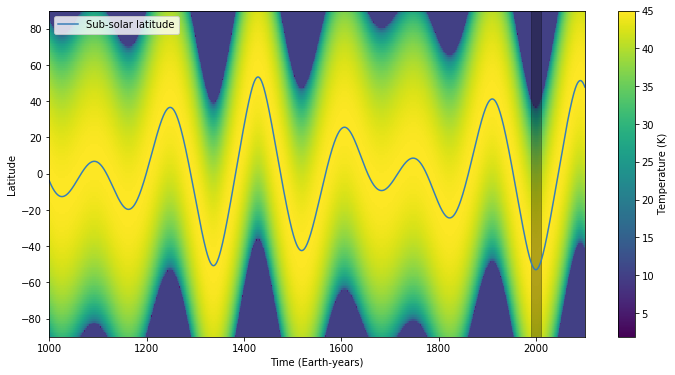

In [180]:
fig,ax = plt.subplots(figsize=(12,6))
plt.imshow(T_patch,aspect='auto',extent=[t[0],t[-1],90,-90])
plt.axvspan(1989,2009,alpha=.3,color='black',zorder=1)


plt.plot(t,phi,label='Sub-solar latitude')
#CS = ax.contour(T_patch,extent=[t[0],t[-1],-90,90],levels=[40],linestyles='dashed')
#ax.clabel(CS, fontsize=9, inline=True,fmt='%1.f')
ax.invert_yaxis()


ax.set_xlim([1000,2100])
ax.set_xlabel('Time (Earth-years)')
ax.set_ylabel('Latitude')
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Temperature (K)')

In [75]:
#checking convergence to periodic methane cycle
pa = 1e-9
pb = 2e-9
pc = 5e-9

a_out, a2, a3 = run_model(fpolar,p0=pa)
b_out, b2, b3 = run_model(fpolar,p0=pb)
c_out, c2, c3 = run_model(fpolar,p0=pc)


All done
All done
All done


(0, 100)

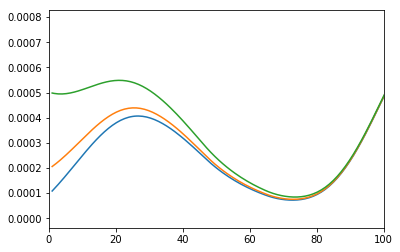

In [78]:
#checking convergence to periodic methane cycle
plt.plot(t,a_out)
plt.plot(t,b_out)
plt.plot(t,c_out)
plt.gca().set_xlim([0,100])

In [131]:
#data for figure 3,4
p0 = 1e-9
cover = .03
fnorth = np.array([cover if l > 0 else 0 for l in lats_avg])
northern_ice,n_T,n_A  = run_model(fnorth,p0=p0)
fsouth = np.array([cover if l < 0 else 0 for l in lats_avg])
southern_ice,s_T,s_A = run_model(fsouth,p0=p0)
fequator = np.array([cover if np.abs(l) < 45 else 0 for l in lats_avg])
equator_ice,e_T,e_A = run_model(fequator,p0=p0)
fpolar = np.array([cover if np.abs(l) > 75 else 0 for l in lats_avg])
polar_ice,p_T,p_A = run_model(fpolar,p0=p0)

fNpole = np.array([cover if l > 75 else 0 for l in lats_avg])
Npolar_ice,Np_T,Np_A = run_model(fNpole,p0=p0)

fSpole = np.array([cover if l < -75 else 0 for l in lats_avg])
Spolar_ice,Sp_T,Sp_A = run_model(fSpole,p0=p0)


fbelt = np.array([cover if np.abs(l+80) < 5 else 0 for l in lats_avg])
belt_ice,b_T,b_A = run_model(fbelt,p0=p0)



All done
All done
All done
All done
All done
All done
All done


In [132]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 


Text(0,0.5,'Atmospheric pCH$_4$ (Pa)')

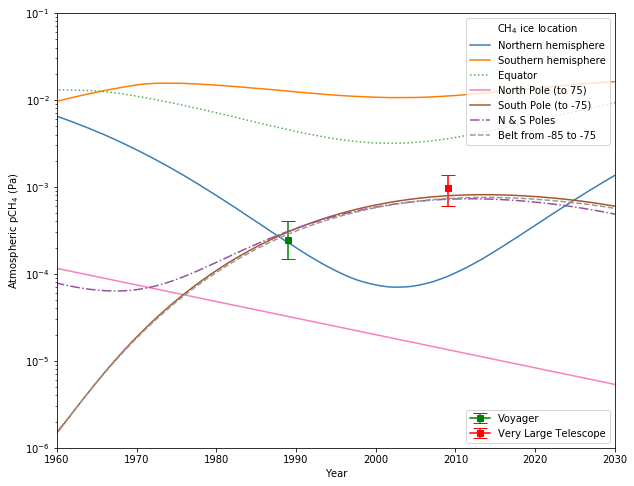

In [160]:
#plots for figure 4

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(t,northern_ice,label='Northern hemisphere')
plt.plot(t,southern_ice,label='Southern hemisphere')
plt.plot(t,equator_ice,linestyle='dotted',label='Equator')
plt.plot(t,Npolar_ice,label='North Pole (to 75)')
plt.plot(t,Spolar_ice,label='South Pole (to -75)')
plt.plot(t,polar_ice,linestyle='dashdot',label='N & S Poles')
plt.plot(t,belt_ice,label='Belt from -85 to -75',linestyle='dashed')
#plt.plot(2009,p2009CH4/pN2,'ro')
#plt.plot(1989,p1989CH4/pN2,'go')
p2009_N2 = 40e-6*100000
err1989 = np.array([[p1989CH4 - p1989lower],[p1989upper- p1989CH4]])
err2009 = np.array([[p2009CH4 - p2009lower],[p2009upper- p2009CH4]])

legend1 = plt.legend(title='CH$_4$ ice location',loc='upper right')
A = plt.errorbar([1989],[p1989CH4],yerr=err1989,capsize=7,color='green',marker='s',label='Voyager')
B = plt.errorbar([2009],[p2009CH4],yerr=err2009,capsize=7,color='red',marker='s',label='Very Large Telescope')
plt.legend([A,B],['Voyager','Very Large Telescope'],loc=4)


plt.gca().add_artist(legend1)
ax.set_xlim([1960,2030])
ax.set_ylim([1e-6,1e-1])
ax.set_yscale('log')
ax.set_xlabel('Year')
ax.set_ylabel('Atmospheric pCH$_4$ (Pa)')


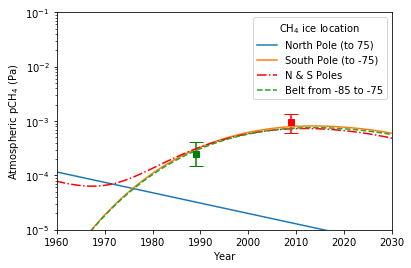

In [81]:

fig, ax = plt.subplots()
# plt.plot(t,northern_ice,label='Northern hemisphere')
# plt.plot(t,southern_ice,linestyle='dashed',label='Southern hemisphere')
# plt.plot(t,equator_ice,linestyle='dotted',label='Equator')
plt.plot(t,Npolar_ice,label='North Pole (to 75)')
plt.plot(t,Spolar_ice,label='South Pole (to -75)')

plt.plot(t,polar_ice,linestyle='dashdot',label='N & S Poles',c='red')


plt.plot(t,belt_ice,label='Belt from -85 to -75',linestyle='dashed')
#plt.plot(2009,p2009CH4/pN2,'ro')
#plt.plot(1989,p1989CH4/pN2,'go')
p2009_N2 = 40e-6*100000
err1989 = np.array([[p1989CH4 - p1989lower],[p1989upper- p1989CH4]])
err2009 = np.array([[p2009CH4 - p2009lower],[p2009upper- p2009CH4]])
plt.errorbar([1989],[p1989CH4],yerr=err1989,capsize=7,color='green',marker='s')#,label='Voyager')
plt.errorbar([2009],[p2009CH4],yerr=err2009,capsize=7,color='red',marker='s')#,label='VLT')
ax.set_xlim([1960,2030])
ax.set_ylim([1e-5,1e-1])
ax.set_yscale('log')
ax.set_xlabel('Year')
ax.set_ylabel('Atmospheric pCH$_4$ (Pa)')
plt.legend(title='CH$_4$ ice location',loc='upper right')


In [121]:
#belts for figure 3
data = {}
latlist = np.linspace(-85,0,18)
cover = .03
for blat in latlist:
    f = np.array([cover if np.abs(l-blat) < 5 else 0 for l in lats_avg])
    ice_out, T_out, A_out = run_model(f,p0=p0)
    data[str(int(blat))] = ice_out

All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done


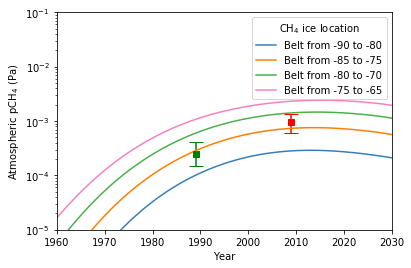

In [122]:
fig, ax = plt.subplots()
sel_list = [-85., -80., -75., -70.]
for blat in sel_list:
    plt.plot(t,data[str(int(blat))],label='Belt from '+str(int(blat-5))+' to '+str(int(blat+5)))
    i+=1
p2009_N2 = 40e-6*100000
err1989 = np.array([[p1989CH4 - p1989lower],[p1989upper- p1989CH4]])
err2009 = np.array([[p2009CH4 - p2009lower],[p2009upper- p2009CH4]])
plt.errorbar([1989],[p1989CH4],yerr=err1989,capsize=7,color='green',marker='s')#,label='Voyager')
plt.errorbar([2009],[p2009CH4],yerr=err2009,capsize=7,color='red',marker='s')#,label='VLT')
ax.set_xlim([1960,2030])
ax.set_ylim([1e-5,1e-1])
ax.set_yscale('log')
ax.set_xlabel('Year')
ax.set_ylabel('Atmospheric pCH$_4$ (Pa)')
plt.legend(title='CH$_4$ ice location',loc='upper right')

In [123]:
#polar caps for fig 3
data2 = {}
latlist = np.linspace(-85,0,18)
cover = .03
for blat in latlist:
    f = np.array([cover if l < blat else 0 for l in lats_avg])
    ice_out, T_out, A_out = run_model(f,p0=p0)
    data2[str(int(blat))] = ice_out

All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done
All done


Text(0,0.5,'Atmospheric pCH$_4$ (Pa)')

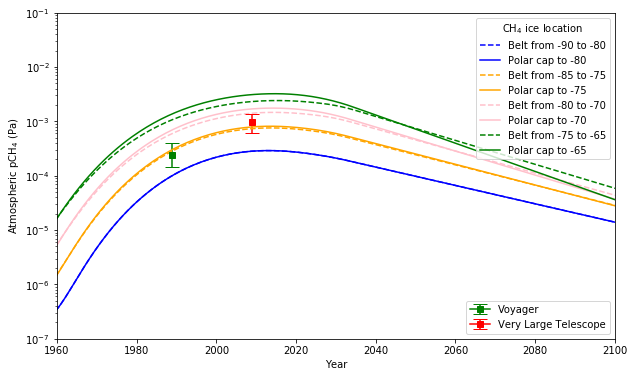

In [155]:
#plot fig 3
fig, ax = plt.subplots(figsize=(10,6))
sel_list = [-85., -80., -75., -70.]
colors = ['blue','orange','pink','green']
i = 0
for blat in sel_list:
    col = colors[i]
    plt.plot(t,data[str(int(blat))],label='Belt from '+str(int(blat-5))+' to '+str(int(blat+5)),linestyle='dashed',c=col)
    plt.plot(t,data2[str(int(blat+5))],label='Polar cap to '+str(int(blat+5)),c=col)

    i+=1
p2009_N2 = 40e-6*100000
err1989 = np.array([[p1989CH4 - p1989lower],[p1989upper- p1989CH4]])
err2009 = np.array([[p2009CH4 - p2009lower],[p2009upper- p2009CH4]])
legend1 = plt.legend(title='CH$_4$ ice location',loc='upper right')


A = plt.errorbar([1989],[p1989CH4],yerr=err1989,capsize=7,color='green',marker='s',label='Voyager')
B = plt.errorbar([2009],[p2009CH4],yerr=err2009,capsize=7,color='red',marker='s',label='Very Large Telescope')
plt.legend([A,B],['Voyager','Very Large Telescope'],loc=4)
plt.gca().add_artist(legend1)
ax.set_xlim([1960,2100])
ax.set_ylim([1e-7,1e-1])
ax.set_yscale('log')
ax.set_xlabel('Year')
ax.set_ylabel('Atmospheric pCH$_4$ (Pa)')


All code below is supplemental

Text(0,0.5,'Latitude')

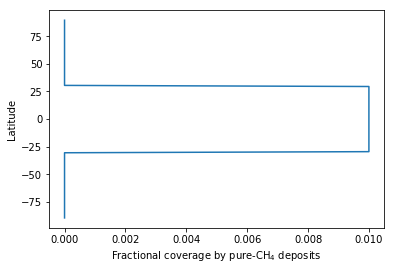

In [1542]:
#plt.plot(fbelt)
plt.plot(fequator,lats_avg)
plt.xlabel('Fractional coverage by pure-CH$_4$ deposits')
plt.ylabel('Latitude')

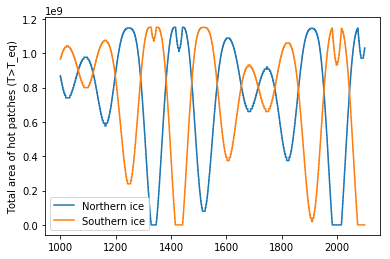

In [1136]:
plt.plot(t,n_A,label='Northern ice')
plt.plot(t,s_A,label='Southern ice')
plt.ylabel('Total area of hot patches (T>T_eq)')
plt.legend()

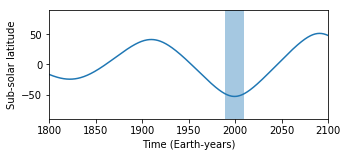

In [1483]:
fig,ax = plt.subplots(figsize=(5, 2))
plt.plot(t,phi)
plt.xlabel('Time (Earth-years)')
plt.ylabel('Sub-solar latitude')
ax.set_ylim([-90,90])
ax.set_xlim([1800,2100])
plt.axvspan(1989,2009,alpha=.4)

In [510]:
n = 4e11 #cm^-3
n = n*100*100*100 #m^-3
p = n/N_A *R*38

In [535]:
M = 16.04/1000 #kg/mol
rho = n*M/N_A
V = 4/3*np.pi*((Radius+20000)**3 - Radius**3)

In [536]:
V*rho/Δm

-73.02729375012093

(1000, 3000)

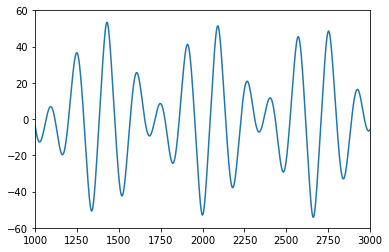

In [131]:
fig,ax = plt.subplots()
plt.plot(t,phi)
ax.set_ylim([-60,60])
ax.set_xlim([1000,3000])

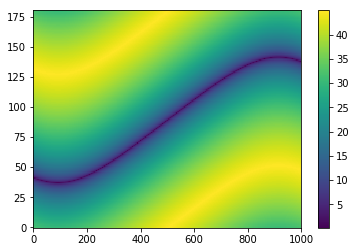

In [566]:
plt.imshow(T_patch,aspect='auto')
plt.gca().invert_yaxis()
plt.colorbar()